### https://towardsdatascience.com/demystifying-gans-in-tensorflow-2-0-9890834ab3d9

# 1. Data Preprocessing

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Mnist dataset

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [5]:
batch_size = 256
buffer_size = train_images.shape[0]
epochs = 300

# output directory where the images of the generator are stored
output_idr = 'img'

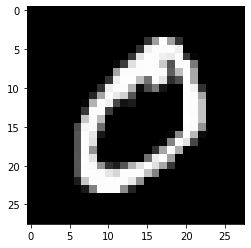

In [7]:
plt.imshow(train_images[1], cmap='gray')

In [8]:
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5

train_dataset = tf.data.Dataset.from_tensor_slices(
    train_images.reshape(train_images.shape[0],784)).shuffle(buffer_size).batch(batch_size)

# 2. Modeling

In [9]:
from tensorflow.keras import layers

## (1) Generator

- output a vector of size 784
- (later) reshape the vector back to 28*28 (=original size of images)
- 100 dimensional noise
- 'generate_noise' = create random data points fromt he uniform distribution

In [11]:
class Generator(tf.keras.Model):
    
    def __init__(self, random_noise_size=100):
        super().__init__(name='generator')
        self.input_layer = layers.Dense(units=random_noise_size)
        self.dense_1 = layers.Dense(units=128)
        self.leaky_1 = layers.LeakyReLU(alpha=0.01)
        self.dense_2 = layers.Dense(units=128)
        self.leaky_2 = layers.LeakyReLU(alpha=0.01)
        self.dense_3 = layers.Dense(units=256)
        self.leaky_3 = layers.LeakyReLU(alpha=0.01)
        self.output_layer = layers.Dense(units=784, activation='tanh')
        
    def call(self, x):
        x = self.input_layer(x)
        x = self.dense_1(x)
        x = self.leaky_1(x)
        x = self.dense_2(x)
        x = self.leaky_2(x)
        x = self.dense_3(x)
        x = self.leaky_3(x)
        x = self.output_layer(x)
        return x
    
    def generate_noise(self, batch_size, noise_size):
        noise = np.random.uniform(-1,1,size=(batch_size,noise_size))
        return noise

## (2) Discriminator

In [23]:
class Discriminator(tf.keras.Model):
    
    def __init__(self):
        super().__init__(name='discriminator')
        self.input_layer = layers.Dense(units=784)
        self.dense_1 = layers.Dense(units=128)
        self.leaky_1 = layers.LeakyReLU(alpha=0.01)
        self.dense_2 = layers.Dense(units=128)
        self.leaky_2 = layers.LeakyReLU(alpha=0.01)
        self.dense_3 = layers.Dense(units=128)
        self.leaky_3 = layers.LeakyReLU(alpha=0.01)
        self.logits = layers.Dense(units=1) # tell whether it is fake or real 
        
    def call(self, x):
        x = self.input_layer(x)
        x = self.dense_1(x)
        x = self.leaky_1(x)
        x = self.dense_2(x)
        x = self.leaky_2(x)
        x = self.dense_3(x)
        x = self.leaky_3(x)
        x = self.logits(x)
        return x

### objective function  & optimizer
- binary cross entropy
* 1) generative_objective
* 2) discriminator_objective

In [20]:
cross_en = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generative_objective(dx_of_gx):
    ce = cross_en(tf.ones_like(dx_of_gx), dx_of_gx)
    return ce

def discriminator_objective(d_x, g_z, smoothing_factor = 0.9)
    # d_x : real output
    # g_z : fake output
    real_loss = cross_en(tf.ones_like(d_x)*smoothing_factor, d_x)
    fake_loss = cross_en(tf.zeros_like(g_z), g_z)
    total_loss = real_loss + fake_loss

In [24]:
gen_opt = tf.keras.optimizers.Adam()
disc_opt = tf.keras.optimizers.Adam()

# 3. Training

- training both network simultaneously!
- 1) some noise is generated (according to the bacth size)
- 2) feed real & fake image to discriminator -> calculate the loss
- 3) (same process) for the generator

In [25]:
@tf.function()
def train_step(gen:Generator, disc:Discriminator,images:np.ndarray, k:int=1, batch_size=32):
    for _ in range(k):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            nosie = gen.generate_noise(batch_size,100)
            g_z = gen(noise) # fake output
            d_x_true = disc(images)
            d_x_fake = disc(g_z)
            
            # (1) discriminator
            disc_loss = discriminator_objective(d_x_true, d_x_fake)
            grads_disc = disc_tape.gradient(disc_loss, disc.trainable_variables)
            disc_opt.apply_gradients(zip(grads_disc, disc.trainable_variables))
            
            # (2) generator
            gen_loss = generator_objective(d_x_fake)
            grads_gen = gen_tape.gradient(gen_loss, gen.trainable_variables)
            gen_opt.apply_gradients(zip(grads_gen, gen.trainable_variables))

In [26]:
def training(dataset, epochs):
    for epoch in range(epochs):
        for batch in dataset:
            train_step(gen,disc,batch,batch_size=bach_size,k=1)
            
        # after ith epoch, plot image
        if epoch%50 == 0:
            fake_image = tf.reshape(gen(seed), shape=(28.28))
            print("{}/{} epochs".format(epoch,epohcs))
            plt.imshow(fake_image,cmap='gray')
            #plt.imsave("{}/{}.png".format(OUTPUT_DIR,epoch),fake_image,cmap='gray')
            